In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.3 MB/s eta 0:00:0000:0100:01


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


In [4]:
event = pd.read_csv('/kaggle/input/google-merchandise-sales-data/events1.csv')
items = pd.read_csv('/kaggle/input/google-merchandise-sales-data/items.csv')
users = pd.read_csv('/kaggle/input/google-merchandise-sales-data/users.csv')

In [5]:
# Rename the 'id' columns in users and items to avoid conflicts during merge
users.rename(columns={'id': 'user_id'}, inplace=True)
items.rename(columns={'id': 'item_id'}, inplace=True)

# First, merge event with users on 'user_id'
merged_data = pd.merge(event, users, how='left', on='user_id')

# Next, merge the result with items on 'item_id'
df = pd.merge(merged_data, items, how='left', on='item_id')

# Display the first few rows of the merged dataset to ensure it was merged correctly
df.head()

,user_id,ga_session_id,country,device,type,item_id,date_x,ltv,date_y,name,brand,variant,category,price_in_usd
0,2133,16909,US,mobile,purchase,94,2020-11-01 00:27:14,34,2020-11-01 00:09:55,Google Large Tote White,Google,Single Option Only,Bags,10
1,2133,16909,US,mobile,purchase,425,2020-11-01 00:27:14,34,2020-11-01 00:09:55,Google Heather Green Speckled Tee,Google,XL,Apparel,21
2,5789,16908,SE,desktop,purchase,1,2020-11-01 01:44:44,72,2020-10-14 00:26:03,Google KeepCup,Google,Single Option Only,New,28
3,5789,16908,SE,desktop,purchase,62,2020-11-01 01:44:44,72,2020-10-14 00:26:03,Google Mini Kick Ball,Google,Single Option Only,Fun,2
4,5808,4267,US,mobile,add_to_cart,842,2020-11-01 03:06:29,0,2020-08-18 03:44:52,Google Infant Hero Onesie Grey,Google,NaN,Apparel,25


In [6]:
# Fill missing values in the country column
df['country'].fillna(df['country'].mode()[0], inplace=True)

# Drop the 'variant' column with a high percentage of missing values
df = df.drop(columns=['variant'])


/tmp/ipykernel_30/1736357951.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['country'].fillna(df['country'].mode()[0], inplace=True)


In [7]:
# Calculate IQR
Q1 = df['price_in_usd'].quantile(0.25)
Q3 = df['price_in_usd'].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
df = df[(df['price_in_usd'] >= (Q1 - 1.5 * IQR)) & (df['price_in_usd'] <= (Q3 + 1.5 * IQR))]


In [8]:
# Convert date_x to datetime format
df['date_x'] = pd.to_datetime(df['date_x'])


In [9]:
# Calculate daily revenue
daily_revenue = df[df['type'] == 'purchase'].groupby(df['date_x'].dt.date).agg({'price_in_usd': 'sum'}).reset_index()
daily_revenue.columns = ['date', 'total_revenue']


In [12]:
# Seasonal differencing (if you observe seasonality)
daily_revenue['seasonal_diff'] = daily_revenue['total_revenue'].diff(7)  # Weekly
adf_test_seasonal = adfuller(daily_revenue['seasonal_diff'].dropna())
print(f"ADF Statistic (Seasonally Differenced): {adf_test_seasonal[0]}")
print(f"p-value (Seasonally Differenced): {adf_test_seasonal[1]}")


ADF Statistic (Seasonally Differenced): -3.315766213447067
p-value (Seasonally Differenced): 0.01418826641449796


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.89481D+00    |proj g|=  2.81392D-01

At iterate    5    f=  6.85791D+00    |proj g|=  1.20346D-01

At iterate   10    f=  6.82497D+00    |proj g|=  5.07425D-02

At iterate   15    f=  6.82113D+00    |proj g|=  3.72830D-03


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['exogenous']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 This problem is unconstrained.



At iterate   20    f=  6.81838D+00    |proj g|=  2.82010D-02

At iterate   25    f=  6.81668D+00    |proj g|=  2.93846D-03

At iterate   30    f=  6.81659D+00    |proj g|=  1.64437D-04

At iterate   35    f=  6.81653D+00    |proj g|=  5.20268D-03

At iterate   40    f=  6.80670D+00    |proj g|=  4.42426D-02

At iterate   45    f=  6.77615D+00    |proj g|=  1.02847D-02

At iterate   50    f=  6.77601D+00    |proj g|=  1.74256D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   1.743D-04   6.776D+00
  F =   6.7760126206411471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


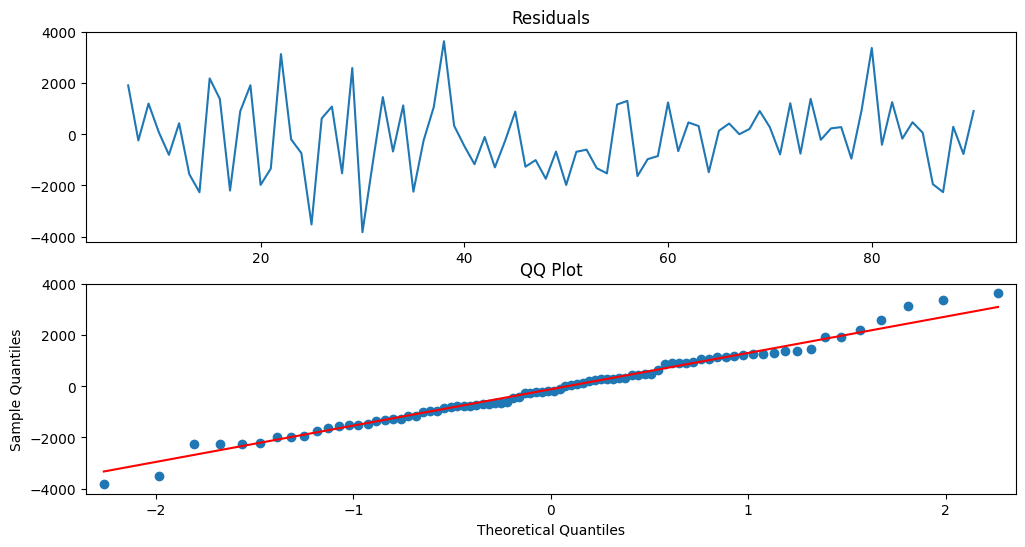

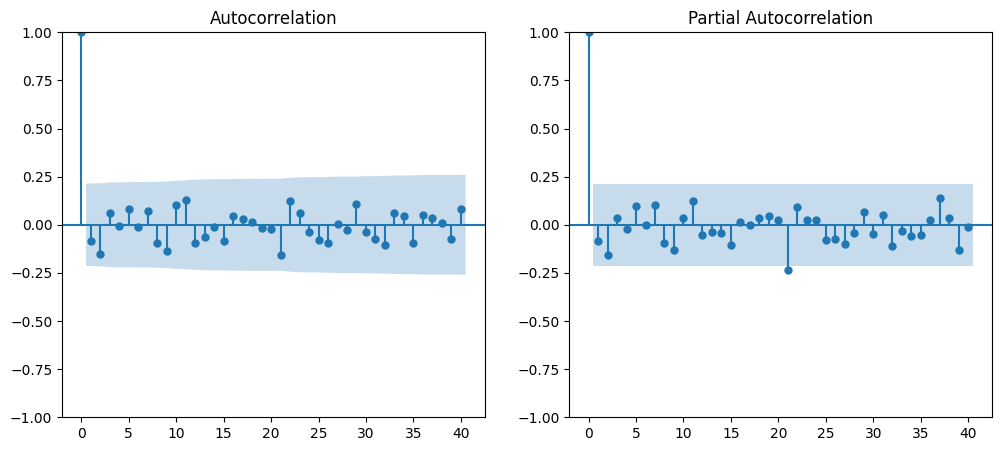

In [15]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Assuming you already have your daily_revenue DataFrame prepared

# Step 1: Data Preprocessing
# Create lagged features
daily_revenue['lag_1'] = daily_revenue['total_revenue'].shift(1)
daily_revenue['lag_2'] = daily_revenue['total_revenue'].shift(2)

# Drop NaN values created by lagging
daily_revenue.dropna(inplace=True)

# Step 2: Check for stationarity using ADF Test
def adf_test(series):
    result = adfuller(series)

adf_test(daily_revenue['total_revenue'])

# Step 3: Try manual SARIMA parameter tuning
# Replace (p, d, q) and (P, D, Q, s) based on your exploratory analysis
# Example: order=(2,1,2) and seasonal_order=(1,1,1,7)
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 7  # Weekly seasonality

manual_model = sm.tsa.SARIMAX(daily_revenue['total_revenue'],
                               order=(p, d, q),
                               seasonal_order=(P, D, Q, s),
                               exogenous=daily_revenue[['lag_1', 'lag_2']],
                               enforce_stationarity=False,
                               enforce_invertibility=False)

results = manual_model.fit()

print(results.summary())

# Check AIC
print(f'Manual AIC: {results.aic}')

# Step 4: Model Diagnostics
# Plot residuals
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('QQ Plot')
plt.show()

# Step 5: ACF and PACF plots for residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax[1])
plt.show()


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['exogenous']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


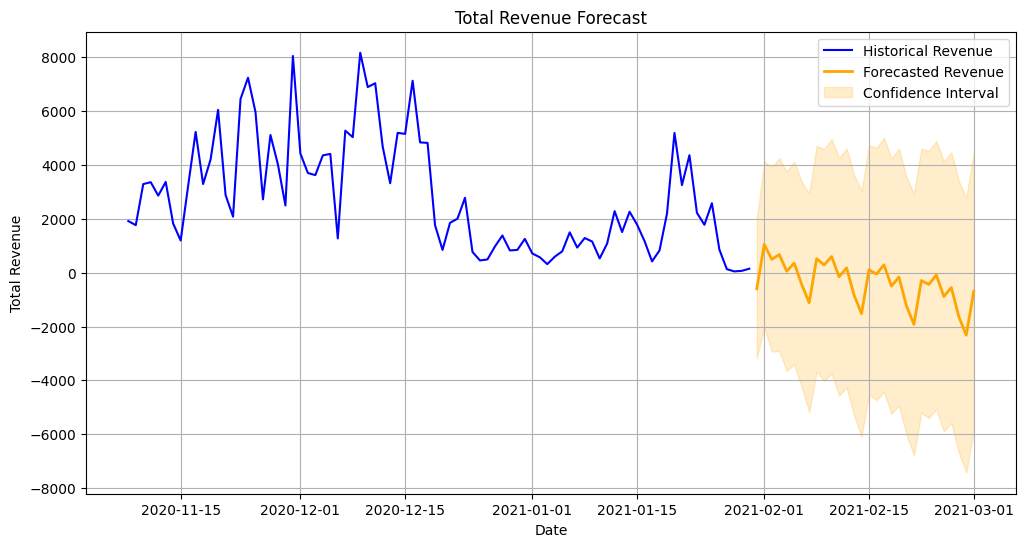

In [16]:
# Generate future forecasts
n_periods = 30  # Forecasting for the next 30 days

# Prepare the exogenous variables for the forecast period
# You need to create new lagged values for the future dates, which may require using previous actual values.
# Here, we can fill them with NaN or zeros and handle appropriately later.
# Alternatively, if you have a known pattern or average, you can set it.
future_lags = pd.DataFrame({
    'lag_1': [daily_revenue['total_revenue'].iloc[-1]] * n_periods,  # Last known value for lag_1
    'lag_2': [daily_revenue['total_revenue'].iloc[-2]] * n_periods   # Second last known value for lag_2
})

# Generate the forecast
forecast_results = results.get_forecast(steps=n_periods, exogenous=future_lags)
forecast_df = forecast_results.summary_frame(alpha=0.05)

# Create a DataFrame with the forecast results
forecast_index = pd.date_range(start=daily_revenue['date'].max() + pd.Timedelta(days=1), periods=n_periods)
forecast_df.index = forecast_index  # Set the forecast index
# Plot historical data and forecast
plt.figure(figsize=(12, 6))

# Plot the historical data
plt.plot(daily_revenue['date'], daily_revenue['total_revenue'], label='Historical Revenue', color='blue')

# Plot the forecast
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecasted Revenue', color='orange', linewidth=2)

# Plot confidence intervals
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='orange', alpha=0.2, label='Confidence Interval')

# Add labels and title
plt.title('Total Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.legend()
plt.grid()
plt.show()



In [17]:
# Cell 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Assuming daily_revenue is already defined and contains 'total_revenue'

# Cell 2: Fit auto_arima model
auto_model = auto_arima(daily_revenue['total_revenue'],
                         seasonal=True,  # Set to True if seasonality is expected
                         m=7,            # Seasonal period (for weekly data)
                         trace=True,     # To print model selection progress
                         error_action='ignore',  # Ignore errors
                         suppress_warnings=True,  # Suppress warnings
                         stepwise=True)  # Stepwise approach for efficiency

# Print the best model's order
print(f"Best order: {auto_model.order}")
print(f"Best seasonal order: {auto_model.seasonal_order}")

# Cell 3: Fit the best SARIMA model found by auto_arima
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
model = ARIMA(daily_revenue['total_revenue'], order=best_order, seasonal_order=best_seasonal_order)
model_fit = model.fit()
print(model_fit.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1468.548, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1445.667, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1446.373, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1466.568, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1463.334, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1447.175, Time=0.25 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=1447.118, Time=0.24 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1452.095, Time=0.05 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=1449.385, Time=0.11 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=1445.171, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=1461.931, Time=0.03 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=1446.842, Time=0.33 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=1

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                    total_revenue   No. Observations:                   84
Model:             ARIMA(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                -715.411
Date:                          Fri, 25 Oct 2024   AIC                           1438.823
Time:                                  19:28:43   BIC                           1448.498
Sample:                                       0   HQIC                          1442.710
                                           - 84                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6338      0.135      4.688      0.000       0.369       0.899
ma.L1         -0.9499      0.077    -12.401      0.

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:                    total_revenue   No. Observations:                   84
Model:             ARIMA(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                -715.411
Date:                          Fri, 25 Oct 2024   AIC                           1438.823
Time:                                  19:28:43   BIC                           1448.498
Sample:                                       0   HQIC                          1442.710
                                           - 84                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6338      0.135      4.688      0.000       0.369       0.899
ma.L1         -0.9499      0.077    -12.401      0.

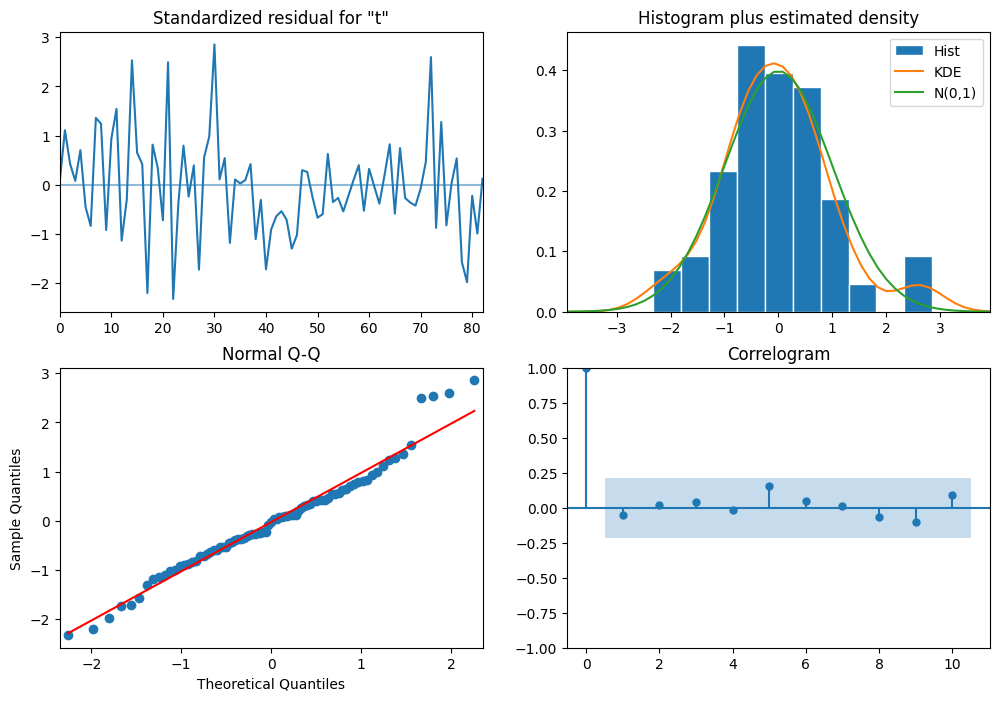

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from prophet import Prophet
import itertools
from statsmodels.tsa.arima.model import ARIMA
# Fit the best model identified by auto_arima
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

# Fit SARIMA model
sarima_model = ARIMA(daily_revenue['total_revenue'], order=best_order, seasonal_order=best_seasonal_order)
sarima_result = sarima_model.fit()

# Print model summary
print(sarima_result.summary())
# Plot diagnostics to check residuals
sarima_result.plot_diagnostics(figsize=(12, 8))
plt.show()


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecasted daily revenue for next 30 days:
           date  forecasted_revenue
84  2021-01-31          474.830139
85  2021-02-01         1195.907083
86  2021-02-02          596.967807
87  2021-02-03          389.631678
88  2021-02-04          437.295888
89  2021-02-05          502.336150
90  2021-02-06          574.644455
91  2021-02-07          751.920094
92  2021-02-08         1107.190957
93  2021-02-09          832.637786
94  2021-02-10          740.151858
95  2021-02-11          766.279356
96  2021-02-12          799.322201
97  2021-02-13          834.975787
98  2021-02-14          919.779039
99  2021-02-15         1088.484178
100 2021-02-16          958.919242
101 2021-02-17          915.382429
102 2021-02-18          927.893709
103 2021-02-19          943.623911
104 2021-02-20          960.555587
105 2021-02-21         1000.725367
106 2021-02-22         1080.587361
107 2021-02-23         1019.286806
108 2021-02-24          998.692867
109 2021-02-25         1004.619752
110 2021-02

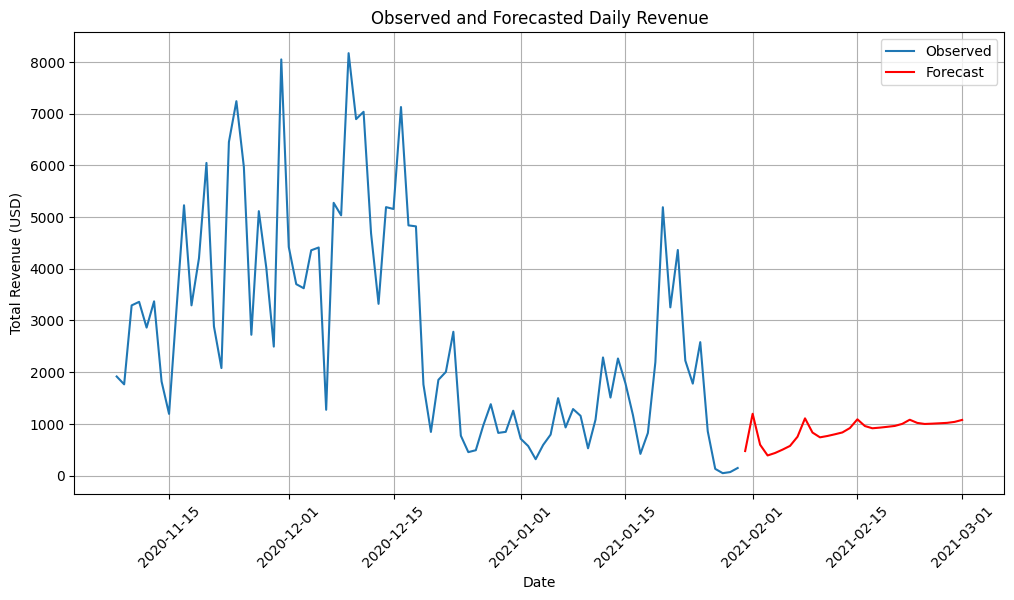

In [19]:
# Cell 10: Forecast future values
forecast = model_fit.forecast(steps=30)  # Forecast next 30 days
forecast_df = pd.DataFrame({'date': pd.date_range(daily_revenue['date'].iloc[-1] + pd.Timedelta(days=1), periods=30),
                            'forecasted_revenue': forecast})
print("Forecasted daily revenue for next 30 days:\n", forecast_df)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue['date'], daily_revenue['total_revenue'], label='Observed')
plt.plot(forecast_df['date'], forecast_df['forecasted_revenue'], label='Forecast', color='red')
plt.title('Observed and Forecasted Daily Revenue')
plt.xlabel('Date')
plt.ylabel('Total Revenue (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from prophet import Prophet
import itertools
from statsmodels.tsa.arima.model import ARIMA
# Prepare the data for Prophet (Prophet expects columns to be named 'ds' for date and 'y' for the target)
prophet_df = daily_revenue.rename(columns={'date': 'ds', 'total_revenue': 'y'})

# Instantiate and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


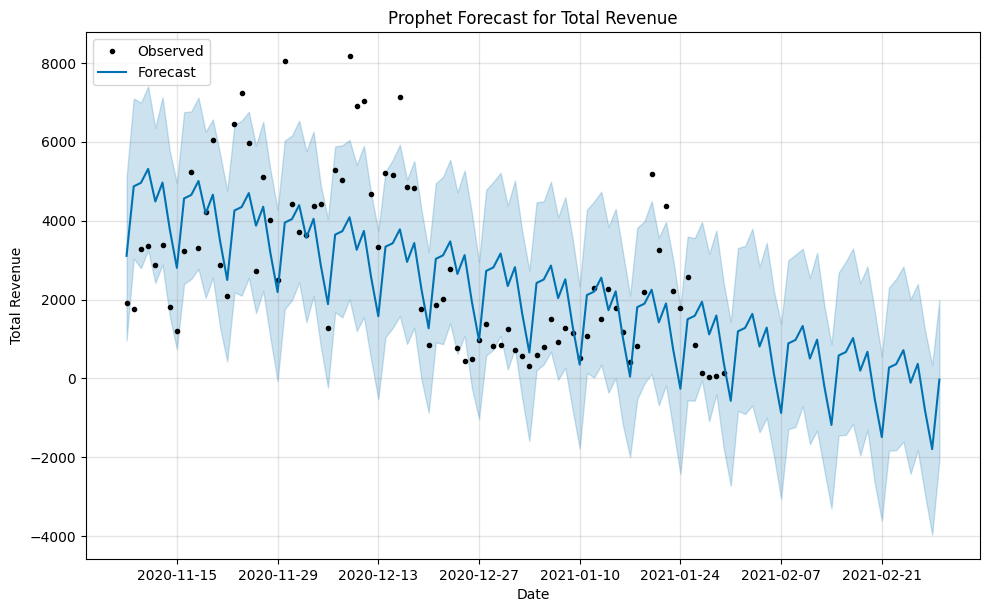

In [21]:
import matplotlib.pyplot as plt

# Assuming `prophet_model` is already defined and fitted
# Forecast for 30 days into the future
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Plot the forecast
fig = prophet_model.plot(forecast)

# Add legend
plt.legend(['Observed', 'Forecast'], loc='upper left')
plt.title('Prophet Forecast for Total Revenue')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.grid(True)

plt.show()
